# Improving The Code

The performance of my code is not very good now. Let's take a look.

In [1]:
import numpy as np
import pandas as pd
import finite_difference

In [40]:
import finite_difference; reload(finite_difference);
d_param = {"f_St": 100.,  # preco do ativo
           "f_sigma": 0.2, # desvio padra do ativo objeto
           "f_time": 1.,  # tempo para vencimento em anos
           "f_r": 0.05,  # taxa de juros anual
           "i_nas": 20,  # passos que o ativo sera discretizado
           "f_K": 100.  # strike da opcao
          }

%time my_option = finite_difference.EuropianCall(**d_param)

CPU times: user 1.07 s, sys: 12 ms, total: 1.08 s
Wall time: 1.08 s


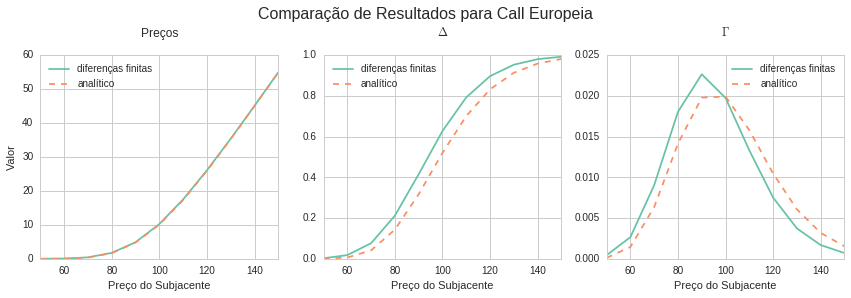

In [41]:
# plotando graficos do inicio do periodo
l_prices = np.arange(50., 151., 1.)
my_option.compare_to_analytical_solutions(l_prices, d_param['f_time'])    

In [56]:
df_opt = my_option.df_opt_prices
df_opt.tail(15).head(9).iloc[:, 0:20:2]

,0.0,0.111111111111,0.222222222222,0.333333333333,0.444444444444,0.555555555556,0.666666666667,0.777777777778,0.888888888889,1.0
60.0,0.0,0.000000,0.000000,0.000173,0.001259,0.004486,0.011279,0.023036,0.040980,0.066094
70.0,0.0,0.000000,0.000676,0.007757,0.028168,0.066767,0.126065,0.206760,0.308349,0.429631
80.0,0.0,0.000000,0.036608,0.140811,0.310256,0.533585,0.798786,1.095650,1.416173,1.754280
90.0,0.0,0.128125,0.592152,1.181664,1.812239,2.449705,3.080486,3.699585,4.305587,4.898543
100.0,0.0,2.253472,3.819229,5.054272,6.109311,7.054239,7.924756,8.740918,9.515021,10.255185
110.0,10.0,10.670640,11.587389,12.534691,13.455152,14.336805,15.180467,15.990032,16.769645,17.522967
120.0,20.0,20.554784,21.158845,21.825706,22.528714,23.246788,23.967303,24.683313,25.391170,26.089063
130.0,30.0,30.554784,31.109308,31.679665,32.271549,32.881648,33.504330,34.134408,34.767822,35.401596
140.0,40.0,40.554784,41.106490,41.657559,42.213263,42.776566,43.347774,43.925717,44.508690,45.094945


Let's see if I can improve that

In [113]:
def opt_value(f_vol, f_intrate, s_ptype, f_strike, f_expiration, f_NAS):
    '''
    Wilmott implementation of finite difference method
    '''
    i_NAS = int(f_NAS)
    dS = 2 * f_strike / f_NAS
    dt = 0.9 / f_vol ** 2 / f_NAS**2
    i_NTS = int(f_expiration/dt) + 1
    dt = f_expiration / float(i_NTS)

    
    na_S = np.zeros(i_NAS + 1)
    na_V = np.zeros([i_NAS + 1, i_NTS+1])
    na_Delta = np.zeros([i_NAS + 1, i_NTS+1])
    na_Gamma = np.zeros([i_NAS + 1, i_NTS+1])
    
    q = 1
    if s_ptype=='P':
        q = -1
        
    for i in xrange(i_NAS+1):
        na_S[i] = i * dS
        na_V[i][0] = max(q * (na_S[i] - f_strike), 0)
    
    for k in xrange(1, i_NTS+1):
        for i in xrange(1, i_NAS):
            f_delta = (na_V[i+1][k-1] - na_V[i-1][k-1]) / (2.*dS)
            f_gamma = (na_V[i+1][k-1] - 2 * na_V[i][k-1] + na_V[i-1][k-1])
            f_gamma /= dS**2 
            f_theta = -0.5*f_vol**2 * na_S[i]**2 * f_gamma
            f_theta -= f_intrate*na_S[i]*f_delta
            f_theta += f_intrate * na_V[i][k-1]
            na_Delta[i][k] = f_delta
            na_Gamma[i][k] = f_gamma
            na_V[i][k] = na_V[i][k-1] - dt * f_theta
        na_V[0][k] = na_V[0][k-1] * (1. - f_intrate * dt)
        na_V[i_NAS][k] = 2 * na_V[i_NAS-1][k] - na_V[i_NAS-2][k]
    
    df_price = pd.DataFrame(na_V)
    df_gamma = pd.DataFrame(na_Gamma)
    df_delta = pd.DataFrame(na_Delta)
    for df in [df_price, df_gamma, df_delta]:
        df.index = na_S
        df.columns = np.arange(i_NTS+1) * dt
    
    
    return df_price, df_delta, df_gamma

In [117]:
d = {'f_vol': 0.2,
     'f_intrate': 0.05,
     's_ptype': 'C',
     'f_strike': 100.,
     'f_expiration': 1.,
     'f_NAS': 20.}

df_price, df_delta, df_gamma = opt_value(**d)

In [118]:
df_price.tail(15).head(9).iloc[:, 0:20:2]

,0.0,0.111111111111,0.222222222222,0.333333333333,0.444444444444,0.555555555556,0.666666666667,0.777777777778,0.888888888889,1.0
60.0,0.0,0.000000,0.000000,0.000173,0.001259,0.004486,0.011279,0.023036,0.040980,0.066094
70.0,0.0,0.000000,0.000676,0.007757,0.028168,0.066767,0.126065,0.206760,0.308349,0.429631
80.0,0.0,0.000000,0.036608,0.140811,0.310256,0.533585,0.798786,1.095650,1.416173,1.754280
90.0,0.0,0.128125,0.592152,1.181664,1.812239,2.449705,3.080486,3.699585,4.305587,4.898543
100.0,0.0,2.253472,3.819229,5.054272,6.109311,7.054239,7.924756,8.740918,9.515021,10.255185
110.0,10.0,10.670640,11.587389,12.534691,13.455152,14.336805,15.180467,15.990032,16.769645,17.522967
120.0,20.0,20.554784,21.158845,21.825706,22.528714,23.246788,23.967303,24.683313,25.391170,26.089063
130.0,30.0,30.554784,31.109308,31.679665,32.271549,32.881648,33.504330,34.134408,34.767822,35.401596
140.0,40.0,40.554784,41.106490,41.657559,42.213263,42.776566,43.347774,43.925717,44.508690,45.094945


Nice... now, let's compare them

In [119]:
%timeit df_test = opt_value(**d)

100 loops, best of 3: 3.27 ms per loop


In [110]:
%timeit my_option = finite_difference.EuropianCall(**d_param)

1 loop, best of 3: 815 ms per loop


It looks bad...but... Let use my implementation, but without calculate the analitical values

In [111]:
reload(finite_difference)

<module 'finite_difference' from 'finite_difference.py'>

In [123]:
%timeit my_option = finite_difference.EuropianCall(**d_param)

1 loop, best of 3: 1.06 s per loop


Ok... much better, but it is still much worst than the function created here. Now, let me see the plots of each solution

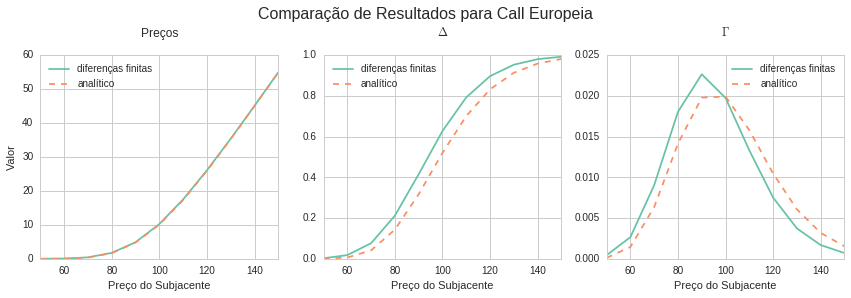

In [124]:
l_prices = np.arange(50., 151., 1.)
my_option.compare_to_analytical_solutions(l_prices, d_param['f_time'])

In [125]:
my_option.df_delta = df_delta
my_option.df_opt_prices = df_price
my_option.df_gamma = df_gamma

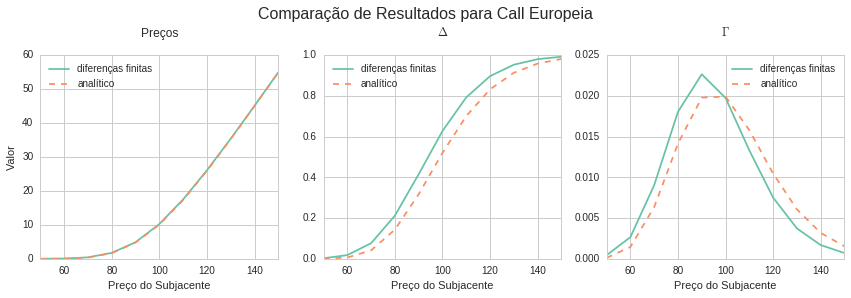

In [126]:
l_prices = np.arange(50., 151., 1.)
my_option.compare_to_analytical_solutions(l_prices, d_param['f_time'])

Now, let's compare the results using uncertain volatility

In [2]:
def opt_value_uvm(f_volm, f_volM, f_intrate, s_ptype, f_strike, f_expiration, f_NAS):
    '''
    Wilmott implementation of finite difference method
    '''
    i_NAS = int(f_NAS)
    dS = 2 * f_strike / f_NAS
    dt = 0.9 / f_volm ** 2 / f_NAS**2
    i_NTS = int(f_expiration/dt) + 1
    dt = f_expiration / float(i_NTS)
    f_sigma = (f_volm+f_volM)/2.

    
    na_S = np.zeros(i_NAS + 1)
    na_V = np.zeros([i_NAS + 1, i_NTS+1])
    na_Delta = np.zeros([i_NAS + 1, i_NTS+1])
    na_Gamma = np.zeros([i_NAS + 1, i_NTS+1])
    
    q = 1
    if s_ptype=='P':
        q = -1
        
    for i in xrange(i_NAS+1):
        na_S[i] = i * dS
        na_V[i][0] = max(q * (na_S[i] - f_strike), 0)
    
    for k in xrange(1, i_NTS+1):
        for i in xrange(1, i_NAS):
            f_delta = (na_V[i+1][k-1] - na_V[i-1][k-1]) / (2.*dS)
            f_gamma = (na_V[i+1][k-1] - 2 * na_V[i][k-1] + na_V[i-1][k-1])
            f_gamma /= dS**2
            
            f_vol = f_sigma
            if f_gamma<0:
                f_vol = f_volM
            elif f_gamma>0:
                f_vol = f_volm
            
            f_theta = -0.5*f_vol**2 * na_S[i]**2 * f_gamma
            f_theta -= f_intrate*na_S[i]*f_delta
            f_theta += f_intrate * na_V[i][k-1]
            na_Delta[i][k] = f_delta
            na_Gamma[i][k] = f_gamma
            na_V[i][k] = na_V[i][k-1] - dt * f_theta
        na_V[0][k] = na_V[0][k-1] * (1. - f_intrate * dt)
        na_V[i_NAS][k] = 2 * na_V[i_NAS-1][k] - na_V[i_NAS-2][k]
    
    df_price = pd.DataFrame(na_V)
    df_gamma = pd.DataFrame(na_Gamma)
    df_delta = pd.DataFrame(na_Delta)
    for df in [df_price, df_gamma, df_delta]:
        df.index = na_S
        df.columns = np.arange(i_NTS+1) * dt
    
    
    return df_price, df_delta, df_gamma

In [143]:
d = {'f_volm': 0.10,
     'f_volM': 0.30,
     'f_intrate': 0.05,
     's_ptype': 'C',
     'f_strike': 100.,
     'f_expiration': 1.,
     'f_NAS': 20.}

%time df_price, df_delta, df_gamma = opt_value_uvm(**d)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 2.68 ms


In [145]:
%timeit df_price, df_delta, df_gamma = opt_value_uvm(**d)

1000 loops, best of 3: 1.7 ms per loop


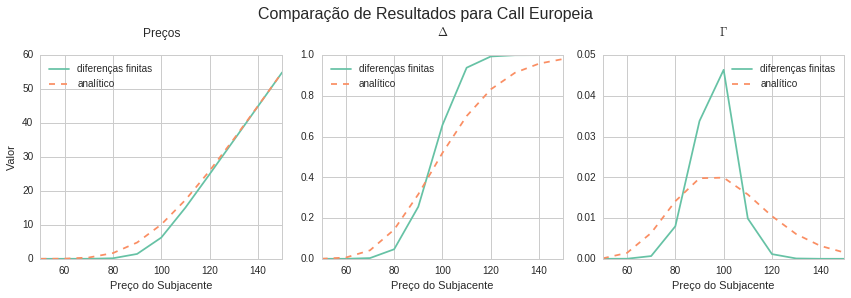

In [146]:
my_option.df_delta = df_delta
my_option.df_opt_prices = df_price
my_option.df_gamma = df_gamma
l_prices = np.arange(50., 151., 1.)
my_option.compare_to_analytical_solutions(l_prices, d_param['f_time'])

So far, so good. The only problem is that the function is very restrict... but it is OK. Now, let try with a butterfly. First, I will use the class already implemented

In [3]:
class FlyEuropianCall(finite_difference.Derivative):
    '''
    A representation of a europian Call Option
    '''
    def __init__(self, f_St, f_sigma, f_time, f_r, i_nas, l_K, l_Qty, i_nts=None):
        '''
        Initialize a EuropianCall object. Save all parameters as attributes
        :param f_St: float. The price of the underline asset
        :param f_sigma: float. A non negative underline volatility
        :param f_time: float. The time remain until the expiration
        :param f_r: float. The free intereset rate
        :param i_nas: integer. Number of asset steps
        :param f_K: float. The strike
        :*param i_nas: integer. Number of asset steps
        '''
        self.l_K = l_K
        self.l_Q = l_Qty
        # inicia variaveis de Derivativo
        super(FlyEuropianCall, self).__init__(f_St=f_St,
                                              f_sigma=f_sigma,
                                              f_time=f_time,
                                              f_r=f_r,
                                              i_nas=i_nas,
                                              f_K=max(l_K),
                                              i_nts=i_nts)
        self.s_name = 'Borboleta de Call Europeia'
        self._go_backwards()
        self._set_all_matrix()

    def _get_analytical_price(self, f_S, f_time):
        '''
        Return the price of the instrument using its analytical solution
        :param f_S: float. the asset price
        :param f_time: float.time to expiration
        '''
        f_rtn = 0.
        for f_K, f_Q in zip(self.l_K, self.l_Q):
            f_d1, f_d2 = finite_difference.get_d1_and_d2(f_S, self.f_sigma, f_time, self.f_r,
                                       f_K)
            exp_r_t = np.exp(-self.f_r * self.f_time)
            S_cdf_d1 = f_S * stats.norm.cdf(f_d1, 0., 1.)
            K_cdf_d2 = f_K * stats.norm.cdf(f_d2, 0., 1.)

            f_rtn += (S_cdf_d1 - K_cdf_d2 * exp_r_t) * f_Q
        
        return f_rtn

    def _get_analytical_delta(self, f_S, f_time):
        '''
        Return the delta of the instrument using its analytical solution
        :param f_S: float. the asset price
        :param f_time: float.time to expiration
        '''
        f_rtn = 0.
        for f_K, f_Q in zip(self.l_K, self.l_Q):
            f_d1, f_d2 = finite_difference.get_d1_and_d2(f_S, self.f_sigma, f_time, self.f_r,
                                       f_K)
            cdf_d1 = stats.norm.cdf(f_d1, 0., 1.)
            f_rtn += cdf_d1 * f_Q
        return f_rtn

    def _get_analytical_gamma(self, f_S, f_time):
        '''
        Return the gamma of the instrument using its analytical solution
        :param f_S: float. the asset price
        :param f_time: float.time to expiration
        '''
        f_rtn = 0.
        for f_K, f_Q in zip(self.l_K, self.l_Q):
            f_d1, f_d2 = finite_difference.get_d1_and_d2(f_S, self.f_sigma, f_time, self.f_r,
                                       f_K)
            pdf_d1 = stats.norm.pdf(f_d1, 0., 1.)
            S_gima_sqrt_t = f_S * self.f_sigma * (f_time**0.5)
            f_rtn += (pdf_d1/S_gima_sqrt_t) * f_Q
        return f_rtn

    def _get_payoff(self, f_asset_price):
        '''
        Get the payoff of the contract
        :param f_asset_price: float. The base asset price
        '''
        f_rtn = 0.
        for f_K, f_Q in zip(self.l_K, self.l_Q):
            f_rtn += max(0, f_asset_price - f_K) * f_Q
        return f_rtn


Now, let's see at the expiration

In [4]:
# import libraries
import matplotlib.pylab as plt
import math
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import time

In [48]:
import finite_difference; reload(finite_difference);
d_param = {"f_St": 100.,  # preco do ativo
           "f_sigma": 0.2, # desvio padra do ativo objeto
           "f_time": 10e-6,  # tempo para vencimento em anos
           "f_r": 0.05,  # taxa de juros anual
           "i_nas": 20,  # passos que o ativo sera discretizado
           "l_K": [90., 100., 110.],  # strike da opcao
           "l_Qty": [0.5, -1., 0.5]  # qtde por leg
          }

%time my_option = FlyEuropianCall(**d_param)

CPU times: user 114 ms, sys: 7.01 ms, total: 121 ms
Wall time: 117 ms


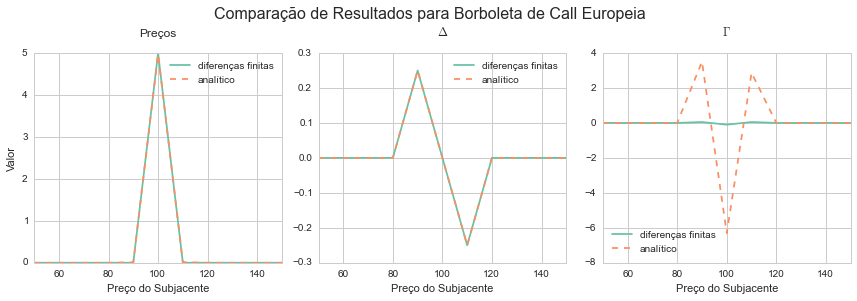

In [51]:
l_prices = np.arange(50., 151., 1.)
my_option.compare_to_analytical_solutions(l_prices, d_param['f_time'])

It is looking right. Now, let's see farther aways from expiration

In [52]:
import finite_difference; reload(finite_difference);
d_param = {"f_St": 100.,  # preco do ativo
           "f_sigma": 0.2, # desvio padra do ativo objeto
           "f_time": 1.,  # tempo para vencimento em anos
           "f_r": 0.05,  # taxa de juros anual
           "i_nas": 20,  # passos que o ativo sera discretizado
           "l_K": [90., 100., 110.],  # strike da opcao
           "l_Qty": [0.5, -1., 0.5]  # qtde por leg
          }

%time my_option = FlyEuropianCall(**d_param)

CPU times: user 1.08 s, sys: 10.5 ms, total: 1.09 s
Wall time: 1.09 s


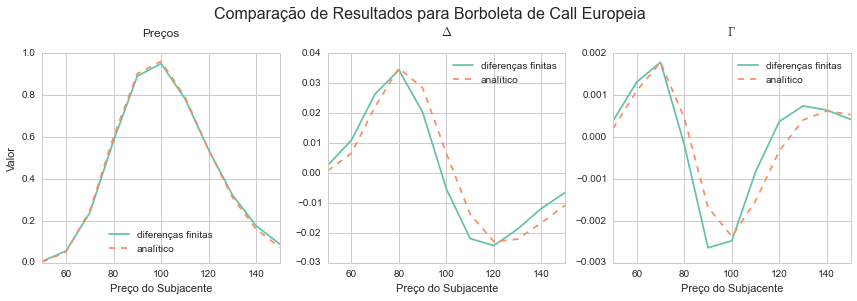

In [53]:
l_prices = np.arange(50., 151., 1.)
my_option.compare_to_analytical_solutions(l_prices, d_param['f_time'])

Intresting... now, let's check using the function created

In [6]:
def opt_value_uvm_fly(f_volm, f_volM, f_intrate, s_ptype, l_strike, l_qty, f_expiration,
                      f_NAS, b_worstcase=True):
    '''
    Wilmott implementation of finite difference method
    '''
    i_NAS = int(f_NAS)
    dS = 2 * max(l_strike) / f_NAS
    dt = 0.9 / f_volM ** 2 / f_NAS**2
    i_NTS = int(f_expiration/dt) + 1
    dt = f_expiration / float(i_NTS)
    f_sigma = (f_volm+f_volM)/2.

    
    na_S = np.zeros(i_NAS + 1)
    na_V = np.zeros([i_NAS + 1, i_NTS+1])
    na_Delta = np.zeros([i_NAS + 1, i_NTS+1])
    na_Gamma = np.zeros([i_NAS + 1, i_NTS+1])
    
    q = 1
    if s_ptype=='P':
        q = -1
        
    for i in xrange(i_NAS+1):
        na_S[i] = i * dS
        f_rtn = 0
        for f_qty, f_K in zip(l_qty, l_strike):
            f_rtn += max(q * (na_S[i] - f_K), 0) * f_qty
        na_V[i][0] = f_rtn
    
    for k in xrange(1, i_NTS+1):
        for i in xrange(1, i_NAS):
            f_delta = (na_V[i+1][k-1] - na_V[i-1][k-1]) / (2.*dS)
            f_gamma = (na_V[i+1][k-1] - 2 * na_V[i][k-1] + na_V[i-1][k-1])
            f_gamma /= dS**2
            
#             f_vol = f_sigma
            if b_worstcase:
                # worst case scenario
                if f_gamma < 0.:
                    f_vol = f_volM
                elif f_gamma >= 0.:
                    f_vol = f_volm
            else:
                # best case scenario
                if f_gamma >= 0.:
                    f_vol = f_volM
                elif f_gamma < 0.:
                    f_vol = f_volm
            
            f_theta = -0.5*f_vol**2 * na_S[i]**2 * f_gamma
            f_theta -= f_intrate*na_S[i]*f_delta
            f_theta += f_intrate * na_V[i][k-1]
            na_Delta[i][k] = f_delta
            na_Gamma[i][k] = f_gamma
            na_V[i][k] = na_V[i][k-1] - dt * f_theta
        na_V[0][k] = na_V[0][k-1] * (1. - f_intrate * dt)
        na_V[i_NAS][k] = 2 * na_V[i_NAS-1][k] - na_V[i_NAS-2][k]
    
    df_price = pd.DataFrame(na_V)
    df_gamma = pd.DataFrame(na_Gamma)
    df_delta = pd.DataFrame(na_Delta)
    for df in [df_price, df_gamma, df_delta]:
        df.index = na_S
        df.columns = np.arange(i_NTS+1) * dt
    
    
    return df_price, df_delta, df_gamma

Testing at the expiration

In [55]:
d = {'f_volm': 0.15,
     'f_volM': 0.25,
     'f_intrate': 0.05,
     's_ptype': 'C',
     'l_strike': [90., 100., 110.],
     'l_qty': [0.5, -1., 0.5],
     'f_expiration':10e-6,
     'f_NAS': 20.}

%time df_price, df_delta, df_gamma = opt_value_uvm_fly(**d)

CPU times: user 1.43 ms, sys: 321 µs, total: 1.75 ms
Wall time: 1.54 ms


In [56]:
%timeit df_price, df_delta, df_gamma = opt_value_uvm_fly(**d)

1000 loops, best of 3: 955 µs per loop


In [57]:
import finite_difference; reload(finite_difference);
d_param = {"f_St": 100.,  # preco do ativo
           "f_sigma": 0.2, # desvio padra do ativo objeto
           "f_time": 10e-6,  # tempo para vencimento em anos
           "f_r": 0.05,  # taxa de juros anual
           "i_nas": 20,  # passos que o ativo sera discretizado
           "l_K": [90., 100., 110.],  # strike da opcao
           "l_Qty": [0.5, -1., 0.5]  # qtde por leg
          }

%time my_option = FlyEuropianCall(**d_param)

CPU times: user 122 ms, sys: 13.2 ms, total: 135 ms
Wall time: 127 ms


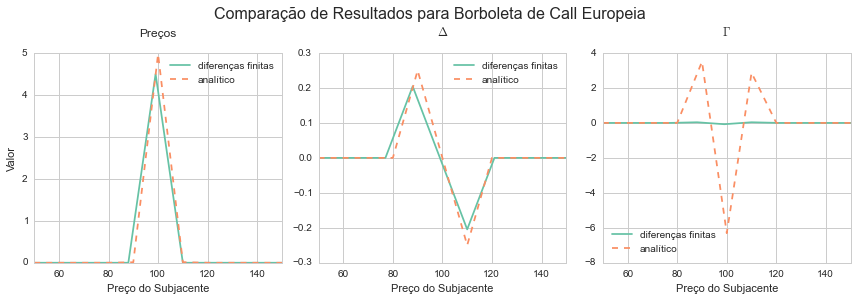

In [58]:
my_option.df_delta = df_delta
my_option.df_opt_prices = df_price
my_option.df_gamma = df_gamma
l_prices = np.arange(50., 151., 1.)
my_option.compare_to_analytical_solutions(l_prices, d_param['f_time'])

Now further the expiration

In [59]:
d = {'f_volm': 0.15,
     'f_volM': 0.25,
     'f_intrate': 0.05,
     's_ptype': 'C',
     'l_strike': [90., 100., 110.],
     'l_qty': [0.5, -1., 0.5],
     'f_expiration':1.,
     'f_NAS': 20.}

%time df_price, df_delta, df_gamma = opt_value_uvm_fly(**d)

CPU times: user 6.87 ms, sys: 1.7 ms, total: 8.57 ms
Wall time: 7.39 ms


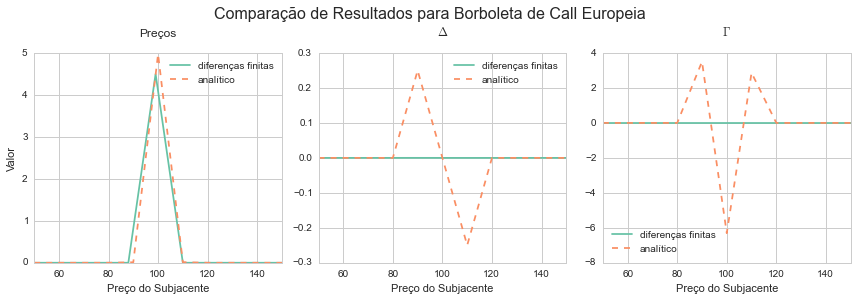

In [60]:
my_option.df_delta = df_delta
my_option.df_opt_prices = df_price
my_option.df_gamma = df_gamma
l_prices = np.arange(50., 151., 1.)
my_option.compare_to_analytical_solutions(l_prices, d_param['f_time'])

Nice.... let's try to find the combination that will result in the best price. What I need to select is a vector $(\lambda_1, \lambda_2, ..., \lambda_n)$, that should be restricted to vary over a siotable range of portfolio combinations and optimize the following function for two options, when we want to get the price for the Bid:

$$f(\lambda_1, \lambda2) = \underset{\lambda_1, \,\lambda_2}{\arg \max}\, V(S_0, t_0\,; \lambda_1, \lambda_2)- \sum_{i=1}^{2} \lambda_{i} v_{i}^{-}(t_0, S_0)$$ 

Where $v_{i}^{-}$ is the prices of each option used in the hedging given by the market ($-$ denotes bid price and $+$, ask price). $V(S_0, t_0\,; \lambda_1, \lambda_2)$ is the price of the whole strategy. So, the function should be evaluated at the current date. Let's try

In [7]:
def best_price(na_x, f_middle, f_S0, na_V0, d_opt_param, f_max=1., b_rtn_price=False):
    '''
    Return the best price fo the option evaluated
    '''
    d = d_opt_param.copy()
    l_qty = list(na_x)[:]
    l_qty.insert(1, f_middle)
    d['l_qty'] = l_qty
    df_price, df_delta, df_gamma = opt_value_uvm_fly(**d)
    f_V =  finite_difference.bilinear_interpolation(f_S0,
                                                    d['f_expiration'],
                                                    df_price)
    f_already_paid = sum(na_V0 * np.array(na_x))
    if b_rtn_price:
        return (f_V - f_already_paid) * f_middle * f_max, df_price   
    return (f_V - f_already_paid) * f_middle * f_max
    

First, let's check which price we would pay if we did a symetric butterfly

In [8]:
d = {'f_volm': 0.25,
     'f_volM': 0.40,
     'f_intrate': 0.00,
     's_ptype': 'P',
     'l_strike': [29., 32., 35.],
     'l_qty': [0., 1., 0.],
     'f_expiration':1./3.,
     'f_NAS': 20.,
     'b_worstcase': True}

In [9]:
# the price given by the worts case when we sell the middle
l_x = [0.5, 0.5]
f_S0 = 31.68
na_V0 = np.array([0.91, 4.63])
f1 = best_price([0., 0.], -1., f_S0, na_V0, d)
f2 = best_price(l_x, -1., f_S0, na_V0, d)

print "I would sell at {:0.2f} without hedging".format(f1)
print "I would sell at {:0.2f} using hedging".format(f2)

I would sell at 3.08 without hedging
I would sell at 2.63 using hedging


In [10]:
# the price given by the worst case when we buy the middle
l_x = [-0.5, -0.5]
f_S0 = 31.68
na_V0 = np.array([0.91, 4.63])
f1 = best_price([0., 0.], 1., f_S0, na_V0, d)
f2 = best_price(l_x, 1., f_S0, na_V0, d)
print "I would buy at {:0.2f} without hedging".format(f1)
print "I would buy at {:0.2f} using hedging".format(f2)

I would buy at 1.95 without hedging
I would buy at 2.22 using hedging


One of the possible outcomes of the minimization/maximization would be

In [11]:
# the price given by the worst case when we buy the middle
l_x = [-0.03, -1.14]
f_S0 = 31.68
na_V0 = np.array([0.91, 4.63])
f1 = best_price([0., 0.], 1., f_S0, na_V0, d)
f2 = best_price(l_x, 1., f_S0, na_V0, d)
print "I would buy at {:0.2f} using hedging".format(f2)


l_x = [0.92, 0.28]
f_S0 = 31.68
na_V0 = np.array([0.91, 4.63])
f1 = best_price([0., 0.], 1., f_S0, na_V0, d)
f2 = best_price(l_x, -1., f_S0, na_V0, d)

print "I would sell at {:0.2f} using hedging".format(f2)

I would buy at 2.42 using hedging
I would sell at 2.51 using hedging


Nice, now, let's [optimize](http://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html) that

In [12]:
import numpy as np
from scipy.optimize import minimize

In [13]:
cons = ({'type': 'ineq', 'fun': lambda x:   np.array([abs(x[1] + x[0]) - 0.5])})

In [14]:
d = {'f_volm': 0.25,
     'f_volM': 0.40,
     'f_intrate': 0.00,
     's_ptype': 'P',
     'l_strike': [29., 32., 35.],
     'l_qty': [0., 1., 0.],
     'f_expiration':1./3.,
     'f_NAS': 20.,
     'b_worstcase': True}

In [15]:
cons = ({'type': 'ineq', 'fun': lambda x:   np.array([abs(x[1] + x[0]) - 0.8])})

In [16]:
l_x = [0.5, 0.5]
f_S0 = 31.68
res = minimize(best_price, l_x, tol=10e-6,
               args=(-1., f_S0, na_V0, d, 1.),
               bounds=((0.2, 1.),(0.2, 1.)),
               constraints=cons)
print res

     fun: 0.15859334020644145
     jac: array([-2.99222979,  3.15359069,  0.        ])
 message: 'Optimization terminated successfully.'
    nfev: 8
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([ 1. ,  0.2])


In [17]:
f_S0 = 31.68
na_V0 = np.array([0.91, 4.63])
f1 = best_price([0., 0.], -1., f_S0, na_V0, d)
f2, df = best_price(res.x, -1., f_S0, na_V0, d, b_rtn_price=True)
print "I would sell at {:0.2f} without hedging".format(f1)
print "I would sell at {:0.2f} using hedging".format(f2)

I would sell at 2.76 without hedging
I would sell at 0.16 using hedging


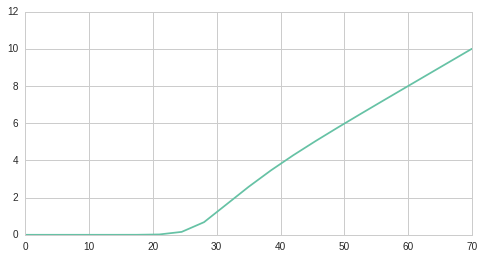

In [21]:
ax = df.iloc[:, -1].plot()

In [80]:
bounds = (-1, -0.3)

In [85]:
bounds[0]

-1

In [32]:
l_x = [-0.5, -0.5]
f_S0 = 31.68
res = minimize(best_price, l_x, tol=10e-6,
               args=(1., f_S0, na_V0, d, -1),
               bounds=((-1., -0.3),(-1., -0.3)),
               constraints=cons)
print res

     fun: -4.5554663347840902
     jac: array([-3.12358153,  3.26066738,  0.        ])
 message: 'Optimization terminated successfully.'
    nfev: 8
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([-0.3, -1. ])


In [33]:
f_S0 = 31.68
na_V0 = np.array([0.91, 4.63])
f1 = best_price([0., 0.], 1., f_S0, na_V0, d)
f2, df = best_price(res.x, 1., f_S0, na_V0, d, b_rtn_price=True)
print "I would buy at {:0.2f} without hedging".format(f1)
print "I would buy at {:0.2f} using hedging".format(f2)

I would buy at 1.63 without hedging
I would buy at 4.56 using hedging


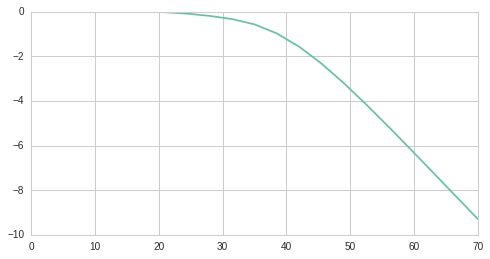

In [24]:
ax = df.iloc[:, -1].plot()

In [28]:
import finite_difference; reload(finite_difference);
d_param = {"f_St": 31.68,  # preco do ativo
           "f_sigma": (0.25 + 0.4)/2., # desvio padra do ativo objeto
           "f_time": 1./3.,  # tempo para vencimento em anos
           "f_r": 0.00,  # taxa de juros anual
           "i_nas": 20,  # passos que o ativo sera discretizado
           "l_K": [29., 32., 35.],  # strike da opcao
           "l_Qty": [res.x[0], 1., res.x[1]]  # qtde por leg
          }

%time my_option = FlyEuropianCall(**d_param)

CPU times: user 1.38 s, sys: 4 ms, total: 1.38 s
Wall time: 1.38 s


CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 6.23 ms


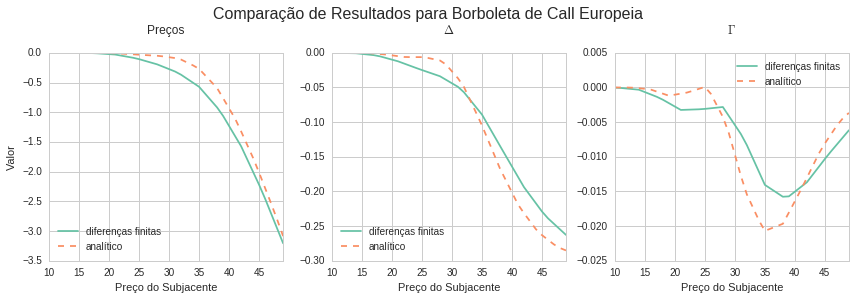

In [29]:
d = {'f_volm': 0.25,
     'f_volM': 0.40,
     'f_intrate': 0.00,
     's_ptype': 'C',
     'l_strike': [29., 32., 35.],
     'l_qty': [res.x[0], 1., res.x[1]],
     'f_expiration':1./3.,
     'f_NAS': 20.,
     'b_worstcase': True}
%time df_price, df_delta, df_gamma = opt_value_uvm_fly(**d)
my_option.df_delta = df_delta
my_option.df_opt_prices = df_price
my_option.df_gamma = df_gamma
l_prices = np.arange(10., 50., 1.)
my_option.compare_to_analytical_solutions(l_prices, d_param['f_time'])

This prices are all very strange for calls .. but I guess that is related to the prices I'm using... that are aprices for Puts. Well.... Let's wrap it in a library and merge the branchs. Yhe next step is calculate the best strategy using market data... and check if it would yield intresting prices to use in day trade, for example. Ow.... first, let's specialize that for calls.... actually, how I would produce a strategy using american and europian options? Well... let's keep going

In [62]:
import finite_difference; reload(finite_difference)

<module 'finite_difference' from 'finite_difference.py'>

In [63]:
d = {'f_volm': 0.25,
     'f_volM': 0.40,
     'f_intrate': 0.00,
     's_ptype': 'C',
     'l_strike': [29., 32., 35.],
     'l_qty': [-0.5, 1., -0.5],
     'f_expiration':1./3.,
     'f_NAS': 20.}
my_uvmoption = finite_difference.EuropianVanillaUvm(**d)

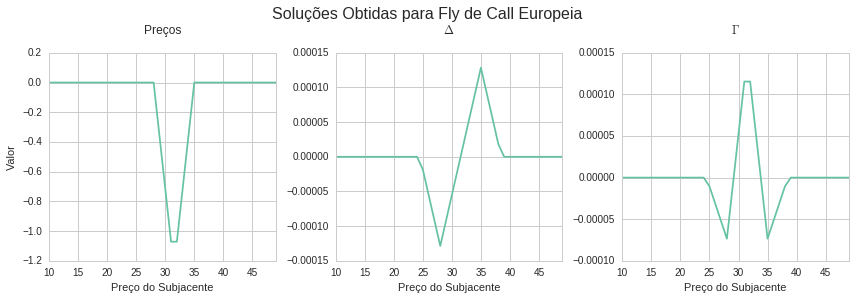

In [65]:
l_prices = np.arange(10., 50., 1.)
my_uvmoption.plot_all_solutions(l_prices, 10e-6)

In [76]:
d = {'f_volm': 0.25,
     'f_volM': 0.40,
     'f_intrate': 0.00,
     's_ptype': 'C',
     'l_strike': [29., 32., 35.],
     'l_qty': [-0.5, 1., -0.5],
     'f_expiration':1./3.,
     'f_NAS': 20.}
%time my_uvmoption = finite_difference.AmericanVanillaUvm(**d)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 5.23 ms


In [78]:
%timeit my_uvmoption = finite_difference.AmericanVanillaUvm(**d)

100 loops, best of 3: 4.55 ms per loop


In [79]:
d = {'f_volm': 0.15,
     'f_volM': 0.25,
     'f_intrate': 0.05,
     's_ptype': 'C',
     'l_strike': [90., 100., 110.],
     'l_qty': [0.5, -1., 0.5],
     'f_expiration':1.,
     'f_NAS': 20.}

%timeit df_price, df_delta, df_gamma = opt_value_uvm_fly(**d)

100 loops, best of 3: 5.25 ms per loop


Nice... it seems that use classes didn't cause any problem here

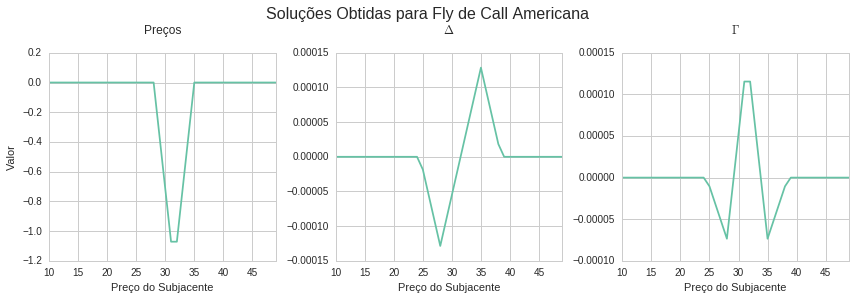

In [77]:
l_prices = np.arange(10., 50., 1.)
my_uvmoption.plot_all_solutions(l_prices, 10e-6)

Well... testing the minimzation part

In [198]:
import finite_difference; reload(finite_difference)

<module 'finite_difference' from 'finite_difference.py'>

In [199]:
d = {'f_volm': 0.25,
     'f_volM': 0.40,
     'f_intrate': 0.00,
     's_ptype': 'C',
     'l_strike': [29., 32., 35.],
     'l_qty': [-0.5, 1., -0.5],
     'f_expiration':1./3.,
     'f_NAS': 20.}
%time my_uvmoption = finite_difference.AmericanVanillaUvm(**d)

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 10.3 ms


In [200]:
f_S0 = 31.68
na_V0 = np.array([0.91, 4.63])
%time l_qty2 = my_uvmoption.get_optimized_satic_hedging(f_S0, na_V0)

CPU times: user 64 ms, sys: 0 ns, total: 64 ms
Wall time: 65 ms


In [201]:
d2 = d.copy()
d2['l_qty'] = l_qty2
%time my_uvmoption2 = finite_difference.AmericanVanillaUvm(**d2)

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 9.71 ms


In [202]:
f1 = my_uvmoption.get_middle_price(f_S0, na_V0, d['f_expiration'])
f2 = my_uvmoption2.get_middle_price(f_S0, na_V0, d['f_expiration'])
print "I would buy at {:0.2f} without hedging".format(f1)
print "I would buy at {:0.2f} if hedging".format(f2)

I would buy at 2.22 without hedging
I would buy at 4.56 if hedging


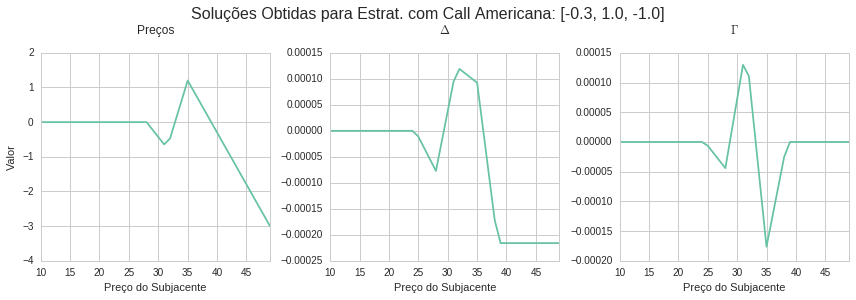

In [203]:
l_prices = np.arange(10., 50., 1.)
my_uvmoption2.plot_all_solutions(l_prices)

Nice... now, let's try with some real numbers

In [254]:
from pandas_datareader import data, wb
import datetime

start = datetime.datetime(2013, 1, 1)
end = datetime.datetime(2016, 5, 29)
df = data.get_data_yahoo("PETR4.SA", start, end)

In [255]:
df.columns = ['PX_OPEN', 'PX_HIGH', 'PX_LOW', 'CLOSE', 'VOLUME','PX_LAST']
df.drop(['CLOSE', 'VOLUME'], inplace=True, axis=1)

In [256]:
df.ix[:,'VOL']=(df['PX_LAST']/df['PX_LAST'].shift()).apply(lambda x: np.log(x))
df_rollingdev=pd.DataFrame(np.zeros([df.shape[0],116]),columns=range(5,121),index=df.index)
for window in xrange(5,121):
    df_rollingdev.ix[:,window]=df['VOL'].rolling(window=window).std()*(252**0.5)

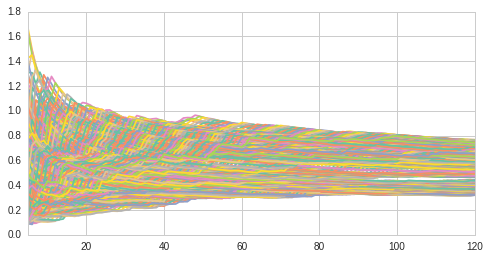

In [257]:
ax = df_rollingdev.T.plot(legend=False)

Here is the cone of volatility.... I know that it is ugly... another day I do it right. For now... I want to know the distribution for 15 days

In [258]:
df_rollingdev[15].describe()

count    840.000000
mean       0.505637
std        0.202432
min        0.151484
25%        0.355708
50%        0.475248
75%        0.612666
max        1.134753
Name: 15, dtype: float64

In [474]:
np.percentile(df_rollingdev[15].dropna().values, 50)

0.47524787344522335

Ok... I will set the maximum volatility to 65% and the minimum to 35%. So, let try that

In [512]:
import finite_difference; reload(finite_difference)
d = {'f_volm': 0.35,
     'f_volM': 0.55,
     'f_intrate': 0.1412,
     's_ptype': 'C',
     'l_strike': [7., 8., 9.],
     'l_qty': [-0.5, 1., -0.5],
     'f_expiration':15./252.,
     'f_NAS': 50.}

In [513]:
d3 = d.copy()
d3['l_qty'] = [0., d3['l_qty'][1], 0.]
%time my_uvmoption_org = finite_difference.AmericanVanillaUvm(**d3)

CPU times: user 20 ms, sys: 12 ms, total: 32 ms
Wall time: 26.9 ms


In [514]:
%time my_uvmoption = finite_difference.AmericanVanillaUvm(**d)

CPU times: user 28 ms, sys: 0 ns, total: 28 ms
Wall time: 25.3 ms


In [515]:
f_S0 = 8.16
na_V0 = np.array([1.33, 0.24])
%time l_qty2 = my_uvmoption.get_optimized_satic_hedging(f_S0, na_V0)
d2 = d.copy()
d2['l_qty'] = l_qty2
%time my_uvmoption2 = finite_difference.AmericanVanillaUvm(**d2)

CPU times: user 580 ms, sys: 12 ms, total: 592 ms
Wall time: 587 ms
CPU times: user 24 ms, sys: 0 ns, total: 24 ms
Wall time: 22 ms


In [516]:
f1 = my_uvmoption.get_middle_price(f_S0, na_V0, d['f_expiration'])
f2 = my_uvmoption2.get_middle_price(f_S0, na_V0, d['f_expiration'])
print "The current price is {:0.2f}".format(0.62)
print "I would buy at {:0.2f} hedging with a butterfly, when using UVM".format(f1)
print "I would buy at {:0.2f} if optimal static hedging".format(f2)

The current price is 0.62
I would buy at 0.53 hedging with a butterfly, when using UVM
I would buy at 0.58 if optimal static hedging


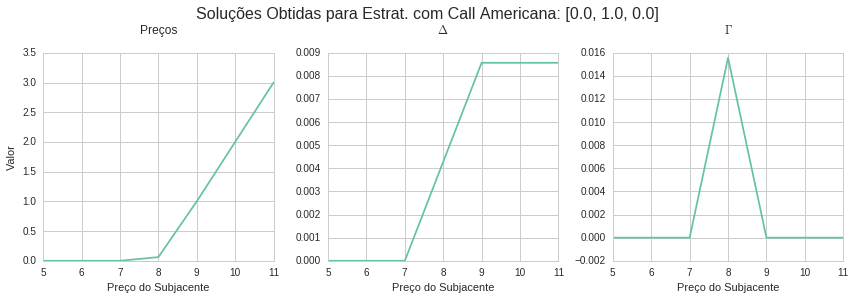

In [517]:
l_prices = np.arange(5., 12., 1.)
my_uvmoption_org.plot_all_solutions(l_prices)

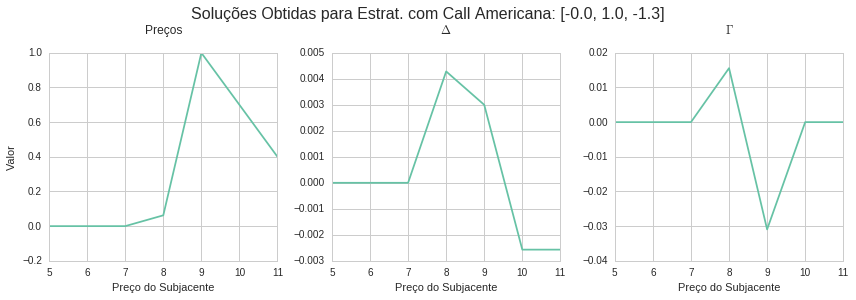

In [518]:
l_prices = np.arange(5., 12., 1.)
my_uvmoption2.plot_all_solutions(l_prices)

... I'm so sure if it is correct... Something that concerns me is that there is an error associated with the use of this method, as can be seem  below

In [13]:
import finite_difference; reload(finite_difference)
d3 = {'f_volm': 0.20,
      'f_volM': 0.30,
      'f_intrate': 0.05,
      's_ptype': 'C',
      'l_strike': [0, 100., 100.],
      'l_qty': [0., -1., 0.],
      'f_expiration':0.5,
      'f_NAS': 60.}
d3['l_qty'] = [0., d3['l_qty'][1], 0.]
my_uvmoption_org_sell = finite_difference.EuropianVanillaUvm(**d3)
d3['l_qty'] = [0., -d3['l_qty'][1], 0.]
my_uvmoption_org_buy = finite_difference.EuropianVanillaUvm(**d3)

In [14]:
l_price = []
l_nas = []
f_S0 = 100.
import finite_difference; reload(finite_difference)
d = {'f_volm': 0.20,
     'f_volM': 0.30,
     'f_intrate': 0.05,
     's_ptype': 'C',
     'l_strike': [90., 100., 100.],
     'l_qty': [0., -1., 0.0],
     'f_expiration':0.5,
     'f_NAS': 60.}
na_V0 = np.array([14.42, 4.22])
for i_nas in xrange(61, 500, 10):
    d3['f_NAS'] = float(i_nas)
    l_nas.append(i_nas)
    my_uvmoption_org_sell = finite_difference.EuropianVanillaUvm(**d3)
    f1 = my_uvmoption_org_sell.get_middle_price(f_S0, na_V0, d['f_expiration'])
    l_price.append(f1)

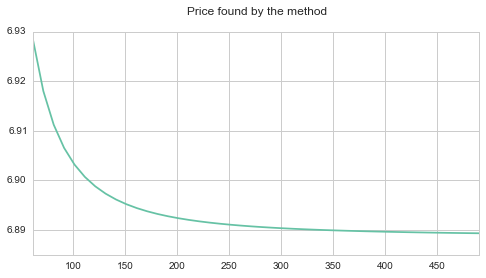

In [15]:
ax = pd.Series(l_price, index=l_nas).plot(legend=False)
ax.set_title('Price found by the method\n');

this behaviour is curious.... maybe is due to the interpolation... well, but 160 steps is good enough. Now, Let's try a Wilmott example. First, let's make the numbers makes sense

In [48]:
import finite_difference; reload(finite_difference)
d = {'f_volm': 0.20,
     'f_volM': 0.20,
     'f_intrate': 0.05,
     's_ptype': 'C',
     'l_strike': [90., 100., 100.],
     'l_qty': [0., -1., 0.0],
     'f_expiration':0.5,
     'f_NAS': 171.}
d3 = d.copy()
d3['l_qty'] = [0., 1., 0.]
my_uvmoption_org_sell = finite_difference.EuropianVanillaUvm(**d3)
d3['l_qty'] = [0., -1., 0.]
my_uvmoption_org_buy = finite_difference.EuropianVanillaUvm(**d3)


In [49]:
f_S0 = 100.
na_V0 = np.array([14.42, 4.22])
f1 = my_uvmoption_org_buy.get_middle_price(f_S0, na_V0, d['f_expiration'])
f2 = my_uvmoption_org_sell.get_middle_price(f_S0, na_V0, d['f_expiration'])
print "I would buy at {:0.2f} without hedging, when using UVM".format(f1)
print "I would sell at {:0.2f} without hedging, when using UVM".format(f2)

I would buy at 6.89 without hedging, when using UVM
I would sell at 6.89 without hedging, when using UVM


In [50]:
my_option = finite_difference.EuropianCall(100., 0.2, 0.5, 0.05, 171., 100.)

In [64]:
my_option.get_information(100., 0.5, 'price_anlt')
print "I would buy at {:0.2f} without hedging, when using B&S".format(f1)

I would buy at 6.89 without hedging, when using B&S


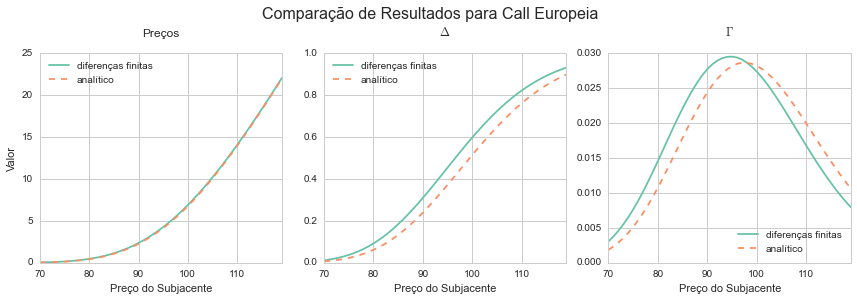

In [63]:
l_prices = np.arange(70., 120., 1.)
my_option.compare_to_analytical_solutions(l_prices, 0.5)

Ok... the prices given by the example were 6.89 and 9.63 (the book says it in a parto and says another prie in another part), and this prices are the same calculated by B&S. Let's test when hedging

In [98]:
import finite_difference; reload(finite_difference)
d = {'f_volm': 0.20,
     'f_volM': 0.30,
     'f_intrate': 0.05,
     's_ptype': 'C',
     'l_strike': [90., 100., 110.],
     'l_qty': [0.5, -1., 0.5],
     'f_expiration':0.5,
     'f_NAS': 171.}
d3 = d.copy()
d3['l_qty'] = [0.5, -1., 0.5]
my_uvmoption_org_sell = finite_difference.EuropianVanillaUvm(**d3)
d3['l_qty'] = [-0.5, 1., -0.5]
%time my_uvmoption_org_buy = finite_difference.EuropianVanillaUvm(**d3)

CPU times: user 2.17 s, sys: 194 ms, total: 2.36 s
Wall time: 2.22 s


In [99]:
f_S0 = 100.
na_V0 = np.array([14.42, 4.22])
f1 = my_uvmoption_org_buy.get_middle_price(f_S0, na_V0, d['f_expiration'])
f2 = my_uvmoption_org_sell.get_middle_price(f_S0, na_V0, d['f_expiration'])
print "I would buy at {:0.2f} without hedging, when using UVM".format(f1)
print "I would sell at {:0.2f} without hedging, when using UVM".format(f2)

I would buy at 7.67 without hedging, when using UVM
I would sell at 8.71 without hedging, when using UVM


The prices should be 7.36 and 8.74... but as the previous example also is wrong in the book... maybe... perhaps.... the buy price is wrong here either. Now, let's optimize

In [100]:
%time l_qBid = my_uvmoption_org_buy.get_optimized_satic_hedging(f_S0, na_V0)

CPU times: user 57.6 s, sys: 2.03 s, total: 59.7 s
Wall time: 58.6 s


In [102]:
# best hedge
l_qBid

[-0.66228653490158784, 1.0, -0.55876755694944269]

In [114]:
d2 = d.copy()
d2['l_qty'] = l_qBid
bid_opt = finite_difference.EuropianVanillaUvm(**d2)
f_S0 = 100.
na_V0 = np.array([14.42, 4.22])
f1 = bid_opt.get_middle_price(f_S0, na_V0, d['f_expiration'])
print "I would buy at {:0.2f}".format(f1)

I would buy at 7.77


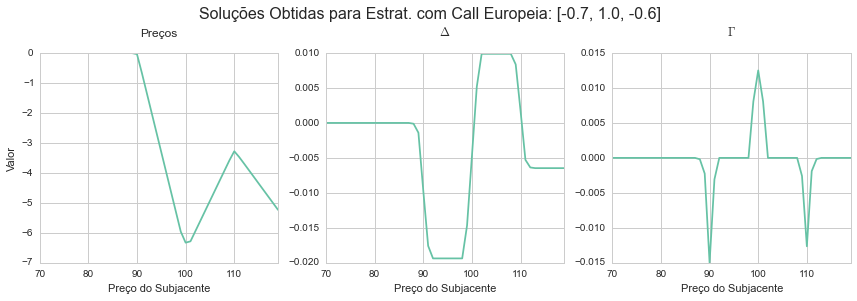

In [115]:
bid_opt.plot_all_solutions(l_prices)

In [104]:
%time l_qAsk = my_uvmoption_org_sell.get_optimized_satic_hedging(f_S0, na_V0)

CPU times: user 45 s, sys: 1.87 s, total: 46.8 s
Wall time: 45.6 s


In [105]:
# best hedge
l_qAsk

[0.62161651820044717, -1.0, 0.53579876560696371]

In [106]:
d2 = d.copy()
d2['l_qty'] = l_qAsk
ask_opt = finite_difference.EuropianVanillaUvm(**d2)
f_S0 = 100.
na_V0 = np.array([14.42, 4.22])
f1 = ask_opt.get_middle_price(f_S0, na_V0, d['f_expiration'])
print "I would sell at {:0.2f}".format(f1)

I would sell at 8.66


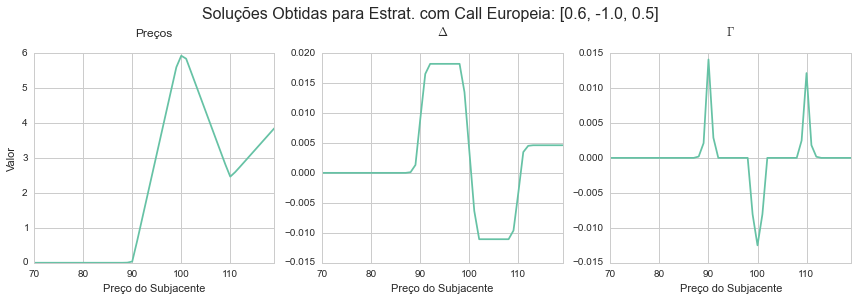

In [113]:
ask_opt.plot_all_solutions(l_prices)

In [739]:
sum(np.array([0.5, 0.5]) * na_V0)

9.3200000000000003

In [745]:
my_uvmoption_org_buy.get_information(100., 0.5, 'price')

-1.6542706360371997

In [741]:
my_uvmoption_org_sell.get_information(100., 0.5, 'price')

0.61304804631702725

In [742]:
9.32 - .61

8.71

In [2]:
#loading style sheet
from IPython.core.display import HTML
HTML(open('ipython_style.css').read())

In [3]:
#changing matplotlib defaults
%matplotlib inline
import seaborn as sns
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (8, 4)})
sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("Set2", 10))